# **Assignment 5**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel→→Restart) and then run all cells (in the menubar, select Cell→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [0]:
NAME = "Vidya Jayaraman"
STUDENT_ID = "1620208"

Some imports we will need:

In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import numpy as np
import string
import textwrap
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, GRU, Bidirectional, Flatten
from tensorflow.keras.models import Model

We will be expanding on the in class exercise and doing classification using an RNN but now with multiple labels instead of binary labels.

We will be using the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/).

Let's load the data:

In [0]:
(X_train, y_train), (_, _) = reuters.load_data()

2113536/2110848 [==============================] - 0s 0us/step


In [0]:
# https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
# Needed to encode our own reviews later

word_dict = reuters.get_word_index()
word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

vocab_size = len(word_dict.keys())

557056/550378 [==============================] - 0s 0us/step


In [0]:
# Needed to decode training data into readable text

inverse_word_dict = {value:key for key,value in word_dict.items()}

In [0]:
X_train = np.array(X_train)
X_train = pad_sequences(X_train)

max_sequence_len = X_train[0].shape[0]
print('Padded to longest sequence length: ', max_sequence_len)

Padded to longest sequence length:  2376


In [0]:
y_train = to_categorical(y_train, 46)
y_train = np.array(y_train)

In [0]:
print('Number of words in vocabulary: ', vocab_size)

Number of words in vocabulary:  30983


In [0]:
def encode_text(text, word_dict, maxlen):
  encoded_text = []
  for raw_word in text.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      encoded_text.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, text not encoded.')
      continue
  return pad_sequences(np.array(encoded_text).reshape(1,-1), maxlen=maxlen)

def decode_text(encoded_text, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_text:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

Let's take a look at an article in our training data:

In [0]:
idx = 144

print(decode_text(X_train[idx], inverse_word_dict), end='\n\n')

print('Topic: ', y_train[idx])

<START> lt black hawk mining inc said it knows of no major activities to account for the recent rise in the company's
stock price the shares rose 11 cts to 88 cts on the toronto stock exchange yesterday the company added that its
application for its proposed acquisition of lt platinova resources ltd and financings are still before the listing
committee of the stock exchange reuter 3

Topic:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##Question 1

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) to achieve at least 60% validation accuracy in 10 epochs or less:

In [0]:
# we should probably use the softmax activation, since there are multiple categories
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 46)(input_layer)

x = LSTM(64)(x) 
# takes more time to train if there are more hidden layers 
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
#x = Dropout(0.8)(x)

x = Dense(46, activation='softmax')(x)
reuters_model = Model(input_layer, x)

# Reminder: We have 46 categories. What final activation do we need to use?

Compile your model and display the summary:

In [0]:
loss = tf.keras.losses.CategoricalCrossentropy()

opt = tf.keras.optimizers.Adam(1e-2)
# adam optimizer has its own set of parameters it has to learn, which might 
# slow down learning
#can add weight decay and momentum 



metrics = 'accuracy'

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2376)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2376, 46)          1425218   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                28416     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                1518  

Train your model:

In [0]:
batchsize = 100

history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10
72/72 [==============================] - 11s 146ms/step - loss: 2.4136 - accuracy: 0.3631 - val_loss: 1.9227 - val_accuracy: 0.4697
Epoch 2/10
72/72 [==============================] - 10s 139ms/step - loss: 1.8810 - accuracy: 0.4973 - val_loss: 1.8031 - val_accuracy: 0.5331
Epoch 3/10
72/72 [==============================] - 10s 140ms/step - loss: 1.7146 - accuracy: 0.5620 - val_loss: 1.7857 - val_accuracy: 0.5582
Epoch 4/10
72/72 [==============================] - 10s 140ms/step - loss: 1.7111 - accuracy: 0.5347 - val_loss: 1.6542 - val_accuracy: 0.5810
Epoch 5/10
72/72 [==============================] - 10s 139ms/step - loss: 1.6066 - accuracy: 0.5711 - val_loss: 1.6761 - val_accuracy: 0.5960
Epoch 6/10
72/72 [==============================] - 10s 140ms/step - loss: 1.4164 - accuracy: 0.6255 - val_loss: 1.6279 - val_accuracy: 0.6077
Epoch 7/10
72/72 [==============================] - 10s 140ms/step - loss: 1.2816 - accuracy: 0.6539 - val_loss: 1.5815 - val_accuracy: 0.6238

Plot the training and validation losses and accuracies:

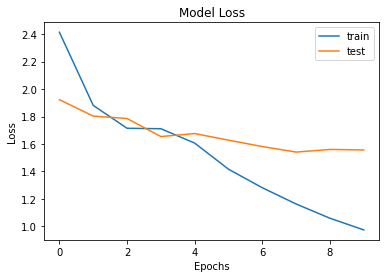

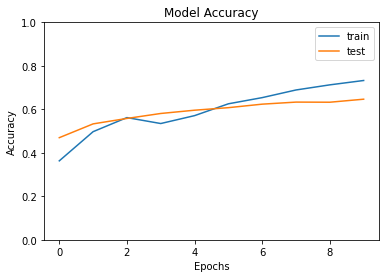

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

##Question 2



We've seen both LSTM and GRU cells as building blocks for RNNs.

Here is a reminder of each of their corresponding architectures:

![Pic](https://drive.google.com/uc?id=1INZQkDev_8rdFxOT9hfAiPWJRT6-N82S)

i) What are the major differences between each?

ii) What are the major advantages of each?

iii) What are the major disadvantages of each?

## YOUR ANSWERS HERE
i) LSTM has seperate forget gate and update gate, while GRU has this combined as just an update gate. So, the LSTM has the forget gate (which decides what information to keep from previous steps) the input gate (for which information to add to the current step) and the output gate(for deciding the next hidden state). And the GRU has the reset gate (which decides what past information to forget) and the update gate(which acts similar to LSTM's forget gate and update gate in deciding which information to forget and which information to add).  So, the LSTM unit computes the amount of the new memory content that is added to the memory cell independently from the forget gate. Meanwhile, the GRU does not independently control the amount of the candidate activation that is added and the GRU does not have a memory cell. Instead, the GRU uses its hidden layer to transfer information. The GRU controls the information flow from the previous activation, while the LSTM does not control the information flow from the previous step.  The LSTM's output gate controls the amount of the memory content that is seen or used by other unnits in the network. Meanwhile, GRU does not control the amount of memory content outputted, so it outputs the full memory content.

ii) The LSTM unit has seperate input and forget gates, while the GRU performs more operations with each of its gates. With less gates, this allows the GRU to be computationally more efficient, train faster, easier to modify, and less complex. This allows for less code and less hidden layers that need to be trained for GRU. Meanwhile, the LSTM is not as simple, but its complexity allows for LSTMs to, in theory, remember longer sequences and this should outperform GRU when requiring long-distance relations. But, otherwise LSTM and GRU have comparable performances.  

ii) The disadvantage of the LSTM is that it is harder to train, since it is more complex. The disadvanatage with the GRU is that it is not as sophisticated as the LSTM and there is less control with the hidden layers with the GRU. So, the GRU is at a disadvantage, if you wanted more control over the training. The GRU may also not remember sequences as long. 